In [20]:
import pandas as pd
import numpy as np
import os
import prody
import math

from pathlib import Path
import pickle
import sys
from sklearn.externals import joblib
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error,explained_variance_score

# preproceessing
from model_transformers import FeaturesInteractions,SkewTransformer,ZeroThreshold

import seaborn as sns

#from mlxtend.plotting import plot_linear_regression
%matplotlib inline


In [40]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)

class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X.iloc[train_index], y.iloc[train_index])
                y_pred = instance.predict(X.iloc[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [41]:
# Test data 
adapt_final = pd.read_csv('../data/ADAPT_3bdy_Test15.csv',index_col=0)

In [42]:
# X and y data transformed to delta G
X = adapt_final.drop(["z-score","ddG_exp"],axis=1)

In [43]:
X.columns.shape

(77,)

In [44]:
lasso_model = joblib.load('Lasso_train15skempiAB_FINAL.pkl')
#elasticnet_model = joblib.load('elasticNet_train15skempiAB_FINAL.pkl')
svr_model = joblib.load('rbfSVRmodel_train15skempiAB_FINAL.pkl')
poly_model = joblib.load("poly2SVRmodel_train15skempiAB_FINAL.pkl")
gbt_model = joblib.load('GBTmodel_train15skempiAB_FINAL.overf.pkl')

stackedModel = joblib.load('stacked_averaged_models_FINAL.pkl')
avgModel = joblib.load('avg_models_FINAL.pkl')

In [45]:
lasso_pred = lasso_model.predict(X)
#elasticnet_pred = elasticnet_model.predict(X)
svr_pred = svr_model.predict(X)
poly_pred = poly_model.predict(X)
gbt_pred = gbt_model.predict(X)
stacked_pred = stackedModel.predict(X)
avgModel_pred = avgModel.predict(X)

In [46]:
pred_stack = np.hstack([adapt_final[["z-score","ddG_exp"]].values,
                        lasso_pred.reshape((-1,1)),gbt_pred.reshape((-1,1)),svr_pred.reshape((-1,1)),
                        poly_pred.reshape((-1,1)),stacked_pred.reshape((-1,1)),avgModel_pred.reshape((-1,1))])
pred_data = pd.DataFrame(pred_stack,columns=["z-score","ddG_exp","Lasso_pred","gbt_pred","svr_pred",
                                             "poly_pred","stacked_pred","avgModel_pred"],index=X.index)


In [47]:
pred_data["mean-pred"] = pred_data.loc[:,["Lasso_pred","gbt_pred","svr_pred","poly_pred"]].mean(axis=1)

In [48]:
pred_data_notna = pred_data.dropna(axis=0)

In [49]:
pred_data_notna

,z-score,ddG_exp,Lasso_pred,gbt_pred,svr_pred,poly_pred,stacked_pred,avgModel_pred,mean-pred
3bdy.protein.H33M.Repair4.clean.pdb,-1.8,0.03,0.305526,0.554520,0.854456,1.387703,0.302284,0.529494,0.775551
3bdy.protein.H33W.Repair4.clean.pdb,-2.4,-0.09,-0.130321,0.240917,0.144476,0.463919,-0.024085,0.105689,0.179748
3bdy.protein.H52R.Repair4.clean.pdb,-2.4,0.30,0.312260,0.044420,0.991662,1.398749,0.410667,0.580476,0.686773
3bdy.protein.H98F.Repair4.clean.pdb,-6.8,-1.18,0.113031,0.107277,-0.147059,0.340742,0.248876,0.210520,0.103498
3bdy.protein.H98H.Repair4.clean.pdb,-4.3,-0.62,0.000236,0.099844,-0.034090,0.411669,0.104966,0.140766,0.119415
3bdy.protein.H98K.Repair4.clean.pdb,-4.1,-0.63,0.138372,0.108436,0.068275,0.521700,0.273311,0.291969,0.209196
3bdy.protein.H98M.Repair4.clean.pdb,-6.5,-1.33,-0.181174,-0.234044,-0.472160,-0.067182,-0.143469,-0.148407,-0.238640
3bdy.protein.H98W.Repair4.clean.pdb,-8.5,-1.23,-0.479855,-0.699778,-1.141712,-0.794320,-0.615407,-0.770250,-0.778916
3bdy.protein.H98Y.Repair4.clean.pdb,-6.4,-0.76,-0.190341,0.119825,-0.812521,-0.533019,-0.231959,-0.386161,-0.354014
3bdy.protein.H99D.Repair4.clean.pdb,-1.6,-0.48,-0.078480,0.192432,0.057038,0.652414,0.206768,0.275495,0.205851


In [50]:
np.sqrt(pred_data_notna.apply(mean_squared_error,axis=0,args=(pred_data_notna["ddG_exp"],)))

z-score          4.531425
ddG_exp          0.000000
Lasso_pred       0.666998
gbt_pred         0.752879
svr_pred         0.604330
poly_pred        0.995778
stacked_pred     0.743233
avgModel_pred    0.739773
mean-pred        0.714331
dtype: float64

In [51]:
r2_score(pred_data_notna["ddG_exp"],pred_data_notna["svr_pred"])

-0.4261708453940052

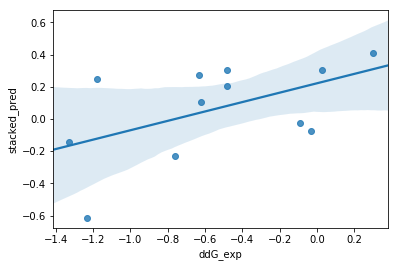

In [52]:
sns.regplot(pred_data_notna["ddG_exp"],pred_data_notna["stacked_pred"])

In [53]:
mcsm_result = pd.read_table("../data/3bdy_mcsm_results.txt")

In [54]:
mcsm_result["mutant"]= mcsm_result["CHAIN"].astype(str)+mcsm_result["RES_POS"].astype(str)+mcsm_result["MUT_RES"].astype(str)
mcsm_result = mcsm_result[["PRED_DDG","mutant"]]
#merge data on mutant column
pred_data_notna["mutant"] = pred_data_notna.reset_index()["index"].str.split(".",expand=True)[2].values

/Users/vfica/miniconda3/envs/bio/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [55]:
pred_data_final = pred_data_notna.merge(mcsm_result,on="mutant")
pred_data_final.set_index("mutant",inplace=True)

In [56]:
r2_score(pred_data_final["ddG_exp"],pred_data_final["PRED_DDG"])

-4.830391261430324

In [57]:
np.sqrt(mean_squared_error(pred_data_final["ddG_exp"],pred_data_final["PRED_DDG"]))

1.221904183368456

In [58]:
pred_data_final.corr()

,z-score,ddG_exp,Lasso_pred,gbt_pred,svr_pred,poly_pred,stacked_pred,avgModel_pred,mean-pred,PRED_DDG
z-score,1.000000,0.632829,0.599963,0.725922,0.789752,0.767015,0.734873,0.789543,0.796857,0.273251
ddG_exp,0.632829,1.000000,0.593768,0.590840,0.742423,0.743441,0.523953,0.631683,0.744191,0.304147
Lasso_pred,0.599963,0.593768,1.000000,0.691513,0.898484,0.904885,0.920689,0.933193,0.935401,-0.128070
gbt_pred,0.725922,0.590840,0.691513,1.000000,0.635781,0.653636,0.763378,0.753234,0.762217,0.322703
svr_pred,0.789752,0.742423,0.898484,0.635781,1.000000,0.987504,0.846322,0.938841,0.979628,-0.010538
poly_pred,0.767015,0.743441,0.904885,0.653636,0.987504,1.000000,0.866063,0.953870,0.984178,0.037263
stacked_pred,0.734873,0.523953,0.920689,0.763378,0.846322,0.866063,1.000000,0.971505,0.904895,0.024330
avgModel_pred,0.789543,0.631683,0.933193,0.753234,0.938841,0.953870,0.971505,1.000000,0.971665,0.027045
mean-pred,0.796857,0.744191,0.935401,0.762217,0.979628,0.984178,0.904895,0.971665,1.000000,0.055056
PRED_DDG,0.273251,0.304147,-0.128070,0.322703,-0.010538,0.037263,0.024330,0.027045,0.055056,1.000000


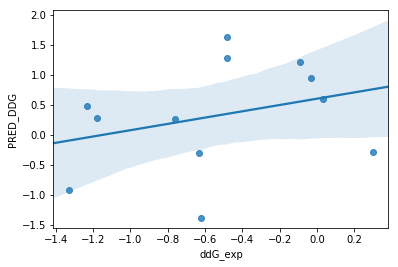

In [44]:
sns.regplot(pred_data_final["ddG_exp"],pred_data_final["PRED_DDG"])